# Sparkify Project 

#### Project Description
As a fictional music streaming service, Sparkify is looking to predict which of it's users are most likely to stop using the service in the future. When users stop using the service it is a loss of potential revenue; users leaving a service is commonly called churn.

#### About Data
Data provided consists of User information along with session information such as User basic details (Gender) along with paid level and session details such as session id, song and artist name and clicks.

#### Approach
To start with, i will be focussing on the exploratory data analysis with which i can able to identify the patterns of data and can handle the missing values or clean the data frame.

Then based on the analysis, i can able to list out the important features for the modelling process. Features need to be converted to numeric in case of categorical values.The features table should have userIds on one axis and a variety of features that can be used to split them on the other. Since there are far fewer churned users than normal users, the f1-score will be a good metric for evaluating the models.

I will be using the sample data from Sparkify (128MB) and not the full data (12GB).

#### Final comment

i will be working on this project using the PySpark so that i can get familiar with it as a tool and to improve the skills

In [1]:
# import libraries
from pyspark.sql import SparkSession

import pyspark.sql.functions as sf
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
import pyspark.sql.types as st

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window

import datetime

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml import Pipeline 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

sns.set_style('whitegrid')

from pyspark.ml.feature import RegexTokenizer, CountVectorizer, \
    IDF, StringIndexer, VectorAssembler, Normalizer, StandardScaler

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("EDA") \
    .getOrCreate()

In [3]:
# Check the parameters which we have provided for Spark session
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.driver.port', '41965'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'EDA'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1575462047802'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', '2986df206796')]

In [4]:
spark

# Load and Clean Dataset

In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data

In [5]:
# Read the mini sparikify dataset (which is in the format of json)
df = spark.read.json('mini_sparkify_event_data.json')

In [6]:
# LEts check the contents of the data frame we read
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Print the first record of data frame to see the data
df.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [8]:
# Check for the missing data
print(str(df.describe("sessionId").show())+"\n"+
      str(df.describe("userid").show()))

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+

+-------+-----------------+
|summary|           userid|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+

None
None


We can see that there are no null values for the session id , however there are some of the null values present in userid field. We need to remove those records

In [9]:
# Check the data frame count
print("Before removing null user ids "+ str(df.count()))

Before removing null user ids 286500


In [10]:
# Just for sanity check purpose, we will look at other variables as well to see the missing values
miss_cnt=df.describe().filter("summary == 'count'").toPandas().T.reset_index()

In [11]:
miss_cnt.columns = ['Name','Non_Miss_Count']
miss_cnt

,Name,Non_Miss_Count
0,summary,count
1,artist,228108
2,auth,286500
3,firstName,278154
4,gender,278154
5,itemInSession,286500
6,lastName,278154
7,length,228108
8,level,286500
9,location,278154


There are multiple columns which are having missing values like "artist", "auth", "iteminsession" etc. But those can be blank due to the reasons that these songs or artists might not have been listed.

We would need to mainly focus on the ids like Session id and user id. Sessionid has no missing values, where as userid has. so we would need to remove the missing values from userid

In [12]:
# Remove null user id records from the data frame
df_clean = df.filter(df["userId"] != "")

In [13]:
# Check the data frame count pre and post of removing the null values from userid
print("Before removing null user ids "+ str(df.count())+"\n"+
      "After  removing null user ids "+ str(df_clean.count()))

Before removing null user ids 286500
After  removing null user ids 278154


In [14]:
# Creating a view so that we can run SQL queries
df_clean.createOrReplaceTempView("df_for_sql")

In [15]:
spark.sql("SELECT * FROM df_for_sql LIMIT 2").show()

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

In [16]:
# Let us get the unqiue values of categorical data items
spark.sql("SELECT distinct artist FROM df_for_sql").show()

+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|         Silverstein|
|           Kate Nash|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|          Carl Craig|
|Dashboard Confess...|
|Yonder Mountain S...|
|           Los Lobos|
|Pete Rock & C.L. ...|
|        Ziggy Marley|
|      Jarabe De Palo|
|               Rufio|
|WC And The Maad C...|
|      Jorge Gonzalez|
|                Silk|
|  The Watts Prophets|
|            La Shica|
|        Generation X|
+--------------------+
only showing top 20 rows



In [17]:
# Check the unqiue user id, session id and pages from the data
spark.sql("SELECT count(distinct userid) as userid_distinct, count(distinct sessionid) as sessionid_distinct,count(distinct page) as page_distinct FROM df_for_sql").show()

+---------------+------------------+-------------+
|userid_distinct|sessionid_distinct|page_distinct|
+---------------+------------------+-------------+
|            225|              2312|           19|
+---------------+------------------+-------------+



In [18]:
# Let us look in to the user level details by checking the status
spark.sql("SELECT level,count(distinct userid) as cnt FROM df_for_sql group by 1 order by count(userid) desc").show()

+-----+---+
|level|cnt|
+-----+---+
| paid|165|
| free|195|
+-----+---+



So it seems there quite a few users who have had both free and paid subscriptions over a period of time, we would need to check whether the recent one is free or paid. We can explore in further sections

In [19]:
spark.sql("SELECT page,count(userid) as cnt FROM df_for_sql group by 1 order by count(userid) desc").show()

+--------------------+------+
|                page|   cnt|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



With the help of above frequency distribution, we can see that Song related event is the by far most used one.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [20]:
# Using the cancellation confirmation define the variable Churn
cacnel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [21]:
# apply to the data frame
df_clean = df_clean.withColumn("Churn", cacnel_event("page"))
df_clean.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0)

In [22]:
# Create a window to have the churn value at userid level
windowval = Window.partitionBy("userid").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [23]:
df_clean = df_clean.withColumn("churn", Fsum("churn").over(windowval))
df_clean.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0)

In [24]:
# Creating a view so that we can run SQL queries
df_clean.createOrReplaceTempView("df_for_sql")

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [25]:
# Looking at the data for page level churn_data
churn_data = df_clean.groupby('page','churn').agg(sf.count('userId'), sf.countDistinct('sessionId')).toPandas()
churn_data

,page,churn,count(userId),count(DISTINCT sessionId)
0,Settings,0,1244,717
1,Thumbs Down,1,496,235
2,Thumbs Up,1,1859,365
3,Add to Playlist,1,1038,299
4,Error,1,32,30
5,About,1,56,49
6,Thumbs Down,0,2050,977
7,Roll Advert,1,967,227
8,Home,0,8410,1867
9,Cancellation Confirmation,1,52,52


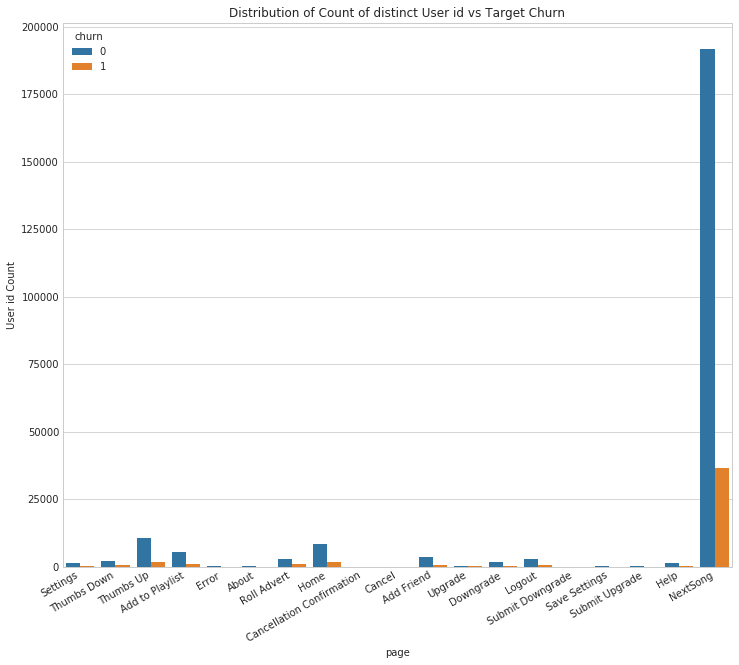

In [26]:
plt.figure(figsize=(12,10))
plt.title("Distribution of Count of distinct User id vs Target Churn");
sns.barplot(x='page',y='count(userId)',hue='churn',data=churn_data)
plt.ylabel('User id Count')
plt.xticks(rotation=30, ha="right");

In [27]:
# Looking at the data for page level churn_data
churn_data = df_clean.groupby('page','churn').agg(sf.countDistinct('userId'), sf.countDistinct('sessionId')).toPandas()
churn_data

,page,churn,count(DISTINCT userId),count(DISTINCT sessionId)
0,Settings,0,152,717
1,Thumbs Down,1,48,235
2,Thumbs Up,1,50,365
3,Add to Playlist,1,50,299
4,Error,1,22,30
5,About,1,31,49
6,Thumbs Down,0,155,977
7,Roll Advert,1,50,227
8,Home,0,172,1867
9,Cancellation Confirmation,1,52,52


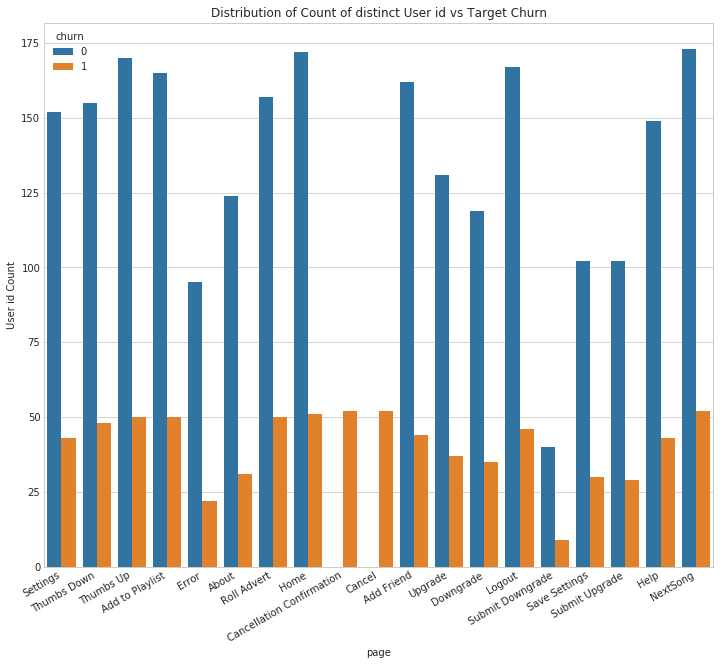

In [28]:
plt.figure(figsize=(12,10))
plt.title("Distribution of Count of distinct User id vs Target Churn");
sns.barplot(x='page',y='count(DISTINCT userId)',hue='churn',data=churn_data)
plt.ylabel('User id Count')
plt.xticks(rotation=30, ha="right");

In [29]:
# Looking at the data for level churn_data
level_data = df_clean.groupby('level','churn').agg(sf.countDistinct('userId')).toPandas()
level_data

,level,churn,count(DISTINCT userId)
0,free,0,149
1,paid,0,129
2,free,1,46
3,paid,1,36


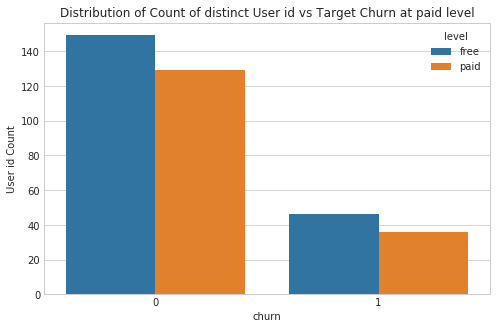

In [30]:
plt.figure(figsize=(8,5))
plt.title("Distribution of Count of distinct User id vs Target Churn at paid level");
sns.barplot(x='churn',y='count(DISTINCT userId)',hue='level',data=level_data)
plt.ylabel('User id Count');

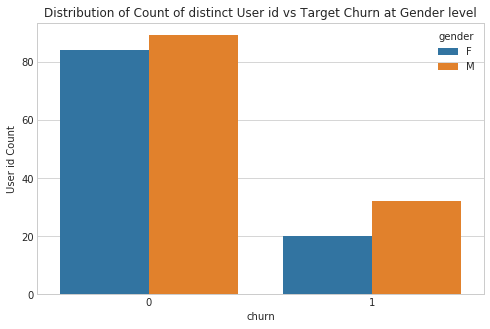

In [31]:
# At gender level
# Looking at the data for page level churn_data
gender_data = df_clean.groupby('gender','churn').agg(sf.countDistinct('userId')).toPandas()
# gender_data


plt.figure(figsize=(8,5))
plt.title("Distribution of Count of distinct User id vs Target Churn at Gender level");
sns.barplot(x='churn',y='count(DISTINCT userId)',hue='gender',data=gender_data)
plt.ylabel('User id Count');

In [32]:
# Lets look at the time metrics to explore the data
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_clean = df_clean.withColumn("hour", get_hour(df_clean.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df_clean = df_clean.withColumn("weekday", get_weekday(df_clean.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df_clean = df_clean.withColumn("day", get_day(df_clean.ts))

In [33]:
df_clean.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='12', weekday='1', day='8')

In [34]:
# Create a method to plot the graphs at certain time frame level
def time_plot(time): 
    """
    Plots the distribution of a given time field
    
    Arguments:
        time (str): The field to graph the distribution of ex: Time, Hour Day
    """
    df_pd = df_clean.filter(df_clean.page == "NextSong").groupby("churn", time).count().orderBy(df_clean[time].cast("float")).toPandas()
    df_pd[time] = pd.to_numeric(df_pd[time])
    plt.figure(figsize=(10,7))
    sns.barplot(x=time, y='count', hue='churn',data=df_pd)

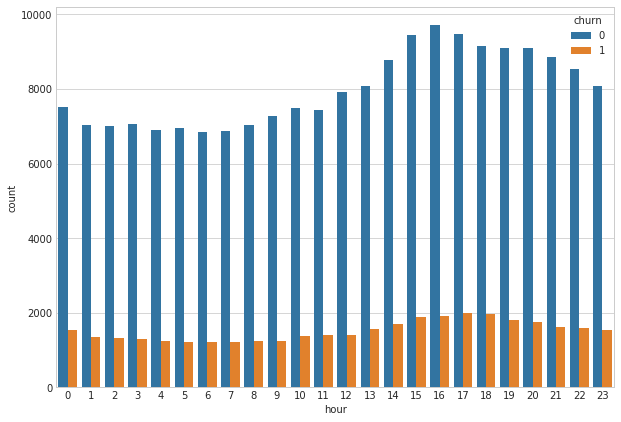

In [35]:
time_plot('hour')

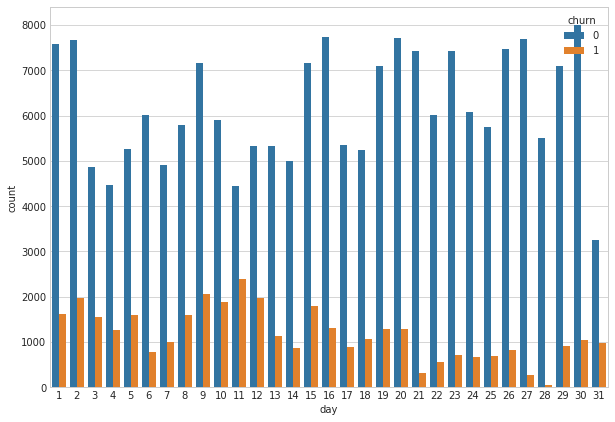

In [36]:
time_plot('day')

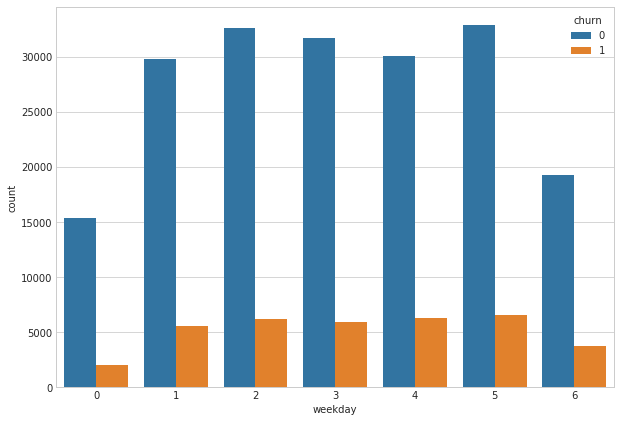

In [37]:
time_plot('weekday')

### Key understanding

Activity of the users depends on the churn, whether it is with respect to time or action



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Based on the above criterion, we can select features like 
1. Gender
2. Paid level (Paid user or Free user)
3. Number of sessions user has paid attention to
4. Number of songs per session
5. Thumbs up and Help option usage

Feature 1:- Gender

In [38]:
feature_gender =spark.sql("""
      SELECT distinct userid,case when gender='M' then 0 else 1 end as gender 
      FROM df_for_sql order by userid
      """)

In [39]:
feature_gender.show(5)

+------+------+
|userid|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
+------+------+
only showing top 5 rows



Feature 2 :- Paid Level (Paid user or free user)

In [40]:
feature_paid =spark.sql("""
        SELECT distinct a.userid,case when a.level='free' then 0 else 1 end as level from
        (SELECT userid,level,ts from df_for_sql)  a inner join
        (SELECT userid,max(ts) as max_ts FROM df_for_sql group by 1)  b
        on a.userid=b.userid and a.ts=b.max_ts
        order by a.userid
        """)      

In [41]:
feature_paid.show(5)

+------+-----+
|userid|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows



Feature 3:- Number of sessions

In [42]:
feature_sessions =spark.sql("""
      SELECT userid,count(distinct sessionid) as session_cnt
      FROM df_for_sql group by userid
      """)

In [43]:
feature_sessions.show(5)

+------+-----------+
|userid|session_cnt|
+------+-----------+
|100010|          7|
|200002|          6|
|   125|          1|
|    51|         10|
|   124|         29|
+------+-----------+
only showing top 5 rows



Feature 4:- Number of songs per session

In [44]:
feature_avgcnt =spark.sql("""
      SELECT userid,avg(session_cnt) avg_songs from 
      (SELECT userid,sessionid,count(sessionid) as session_cnt
      FROM df_for_sql where page='NextSong' group by 1,2) group by 1
      """)

In [45]:
feature_avgcnt.show(5)

+------+------------------+
|userid|         avg_songs|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



Additionally, in general we can see the trend that the churn users may not do below mentioned things
1. like the songs
2. Take the Help option

hence exploring the same

In [46]:
feature_thumps_up = spark.sql("""
    SELECT DISTINCT userId,count(sessionid) as thumsup_cnt
    FROM df_for_sql WHERE page = 'Thumbs Up' group by 1
    """)

In [47]:
feature_thumps_up.show(5)

+------+-----------+
|userId|thumsup_cnt|
+------+-----------+
|100010|         17|
|200002|         21|
|    51|        100|
|   124|        171|
|     7|          7|
+------+-----------+
only showing top 5 rows



In [48]:
feature_help = spark.sql("""
    SELECT DISTINCT userId,count(sessionid) as help_cnt
    FROM df_for_sql WHERE page = 'Help' group by 1
    """)

In [49]:
feature_help.show(5)

+------+--------+
|userId|help_cnt|
+------+--------+
|100010|       2|
|200002|       2|
|    51|      12|
|   124|      23|
|     7|       1|
+------+--------+
only showing top 5 rows



In [50]:
# Finally create a table with Churn value at user id level
feature_churn = spark.sql("""
    SELECT DISTINCT userId,churn
    FROM df_for_sql 
    """)

In [51]:
feature_churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



Merge all the selected features data together to create one final data set for model

In [52]:
# Firstly create a sql compatible tables for all the above data frames
feature_gender.createOrReplaceTempView("feature_gender_sql")
feature_paid.createOrReplaceTempView("feature_paid_sql")
feature_sessions.createOrReplaceTempView("feature_sessions_sql")
feature_avgcnt.createOrReplaceTempView("feature_avgcnt_sql")
feature_thumps_up.createOrReplaceTempView("feature_thumps_up_sql")
feature_help.createOrReplaceTempView("feature_help_sql")
feature_churn.createOrReplaceTempView("feature_churn_sql")

In [53]:
spark.sql("SELECT * from feature_paid_sql limit 5").show()

+------+-----+
|userid|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
+------+-----+



In [54]:
features_final= spark.sql("""
    SELECT gender.userid,gender.gender,
           coalesce(paid.level,0) as level,
           coalesce(sessions.session_cnt,0) as session_cnt,
           coalesce(avgcnt.avg_songs,0) as avg_songs,
           coalesce(thmbsup.thumsup_cnt,0) as thumsup_cnt,
           coalesce(help.help_cnt,0) as help_cnt,
           churn.churn as label
    FROM feature_gender_sql gender  left join  feature_paid_sql paid
    on gender.userid=paid.userid
    left join feature_sessions_sql sessions
    on gender.userid=sessions.userid
    left join feature_avgcnt_sql avgcnt
    on gender.userid=avgcnt.userid
    left join feature_thumps_up_sql thmbsup
    on gender.userid=thmbsup.userid
    left join feature_help_sql help
    on gender.userid=help.userid
    left join feature_churn_sql churn
    on gender.userid=churn.userid
    """)

In [55]:
features_final.show(5)

+------+------+-----+-----------+------------------+-----------+--------+-----+
|userid|gender|level|session_cnt|         avg_songs|thumsup_cnt|help_cnt|label|
+------+------+-----+-----------+------------------+-----------+--------+-----+
|100010|     1|    0|          7|39.285714285714285|         17|       2|    0|
|200002|     0|    1|          6|              64.5|         21|       2|    0|
|   125|     0|    0|          1|               8.0|          0|       0|    1|
|   124|     1|    1|         29|145.67857142857142|        171|      23|    0|
|    51|     0|    1|         10|             211.1|        100|      12|    1|
+------+------+-----+-----------+------------------+-----------+--------+-----+
only showing top 5 rows



# Modeling

Finally, in this section we will split the data set with features in to train and test for the validation of the label (whether user will churn or not)  based on the lessons learnt in course.
Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

As a starting point, we can check the model of logistic regression to see how is the score

We select F-1 score as our evaluation metrics. The reason we use F-1 score here is because it gives us a simple measure of the precision (whether we send offer to the right person) and recall (whether we miss one that we should’ve sent the offer) of the model. We want to identify those who are likely to churn and give them some special offers in trying to keep the customer, but at the same time, we do not want to send too many offers (most likely a monetary incentive) to those who are not as likely to churn and therefore wasting money and resources.

In [60]:
def model_output(model, test_data, metric = 'f1'):
    """ Evaluate a machine learning model's performance 
    
        Input: 
            model(object) - trained model or pipeline object
            metric - the metric used to measure performance
            data - test data on which performance measurement should be performed
        Output:
            score
    """
    
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    predictions = model.transform(test_data)
    
    # calcualte score
    score = evaluator.evaluate(predictions)
    
    return score

In [87]:
assembler = VectorAssembler(inputCols=["gender","level","thumsup_cnt","session_cnt","avg_songs"], outputCol="features")

# Apply the vectorization on the dataset
input_data = assembler.transform(features_final)

In [88]:
features_scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
features_scaler_fit = features_scaler.fit(input_data)
scaled_inputs = features_scaler_fit.transform(input_data)

In [89]:
# Select the output and input features
ml_data = scaled_inputs.select(scaled_inputs.label, scaled_inputs.scaled_features.alias('features'))

In [90]:
# Defining training and testing samples
train, test = ml_data.randomSplit([0.80, 0.20], seed=42)

In [91]:
model_lr = LogisticRegression()
param_grid = ParamGridBuilder() \
    .addGrid(model.regParam,[0.01, 0.1]) \
    .addGrid(model.elasticNetParam,[0.0, 0.5]) \
    .addGrid(model.aggregationDepth,[2, 5]) \
    .build()

In [92]:
crossval_lr = CrossValidator(estimator=model_lr,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3,seed =42)

In [93]:
model_lr_fitted = crossval_lr.fit(train)

In [95]:
model_output(model_lr_fitted, test)

0.5841784989858012

Based on the above model of logistic regression we can see that we have got a good score of 0.58, however let us try to check the same by using the Decision trees

In [96]:
model_dt = DecisionTreeClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model_dt.maxDepth,[3, 5, 10]) \
    .addGrid(model_dt.impurity,['entropy', 'gini']) \
    .build()

In [97]:
crossval_dt = CrossValidator(estimator=model_dt,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3,seed =42)

In [98]:
model_dt_fitted = crossval_dt.fit(train)

In [99]:
model_output(model_dt_fitted, test)

0.5696594427244583

In [100]:
# Random Forest Model
model_rf = RandomForestClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model_rf.maxDepth,[5, 10]) \
    .addGrid(model_rf.impurity,['entropy', 'gini']) \
    .addGrid(model_rf.numTrees ,[20, 10]) \
    .build()

In [101]:
crossval_rf = CrossValidator(estimator=model_rf,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3,seed =42)

In [102]:
model_rf_fitted = crossval_rf.fit(train)

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/opt/spark-2.4.3-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'DecisionTreeClassifier' object has no attribute '_java_obj'


In [103]:
model_output(model_rf_fitted, test)

0.5390374331550801

In [104]:
# GBT Model
model_gbt = GBTClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model_gbt.maxDepth,[3, 5, 10]) \
    .addGrid(model_gbt.maxBins ,[10, 5]) \
    .addGrid(model_gbt.maxIter ,[20, 5]) \
    .build()

In [105]:
crossval_gbt = CrossValidator(estimator=model_gbt,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3,seed =42)

In [107]:
model_gbt_fitted = crossval_gbt.fit(train)

In [111]:
model_output(model_gbt_fitted, test)

0.7584325666208162

#### Summary
Below are the F1 scores for multiple models that i have tried to test based on the seletced feaute set

|SNo| Model                | F1 Score   |
|---|----------------------|------------|
| 1 |Logistic Regression   |       0.584|
| 2 |Decision Trees        |       0.569|
| 3 |Random Forest         |       0.539|
| 4 |GBT (Gradient Boost)  |       0.758|


Based on the above table, we can observe that Gradient Boost algorithm has provided much higher and good f1 score across all the other models with parameters and considering the cross validation

We have implemented a model to predict the churn of music app customer base. 
The process we followed is

1) Removed any null values in the Userid information as that is critical in this analysis

2) Went through the data using the basic EDA to see the pattern of data

3) Selected the features, which i thought are having impact on the customer churn like Gender, Paid Level, Help Thumbsdown 

4) Appied four different models i.e., Logistic regression, Decision trees, Random Forest and GBT to see which is affective

5) This has been routed through parameter passing in the cross validation and grid search technique to get the proper model for identifying the customer churn

5) By this, we found out Gradient Boost has better f1 score

Hence as per my work, i can recommend GBT as modelling technique for customer churn idenitification


### Conclusion

With help of this project, i was able to implement a process for creating a model which can identify the customers of a music app about to churn. With help of EDA i was able to get the list of suitable features which i have used for model. Have considered four different models to try this prediction, interestingly Logistic Regression has the good F1 score compared to rest.

Hence i have improved the model by using the grid search technique and cross validation, it has improved the f1 score slightly which can be used further.

Since this has been done in UDACITY workspace, i have used the sample data (128 MB) rather than the complete data (12GB), i definitely believe that if we explore more and use the complete data set we can have a very good and accurate model

